In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import re
import pandas as pd
import os.path as osp
from pathlib import Path
from os import listdir
from collections import defaultdict
from typing import LiteralString, Sequence, Literal
from datetime import datetime, timedelta

In [2]:
sample_indices = set([41905, 7296, 1639, 48598, 18024, 16049, 14628,
                9144, 48265, 6717, 44348, 48540, 58469, 35741])

In [14]:
def extract_log_pd():
    path = Path("log/")
    files = path.glob("*.log")
    files = [file for file in files if "ubai" not in file.name]
    files = [file for file in files if "rep" not in file.name]
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"[Ss]ample (\d+)(\t| and| for)"
    time_pattern = r"time:* (\d+\.\d+)"

    # Initialize empty dictionary
    sample_times = defaultdict[int|str,list[float]](list)
    sample_robs = defaultdict[int|str,list[str]](list)

    # Read each line of the log
    print(len(files))
    for file in files:
        id_seq = []
        time_seq = []
        robust_seq = []
        with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
            for line in f:
                # Search for the pattern in the line
                match = re.search(sample_no_pattern, line)
                # If a match is found, extract sample number and checking done time
                if match:
                    sample_number = int(match.group(1))
                    id_seq.append(sample_number)
                    if "obust" in line:
                        if "Not" in line:
                            robust_seq.append("Not robust")
                        else:
                            robust_seq.append("Robust")
                    else:
                        robust_seq.append("Unknown")
                    if "|" not in line:
                        continue
                match = re.search(time_pattern, line)
                if match:
                    checking_time = float(match.group(1))
                    time_seq.append(checking_time)
        for id in sample_indices:
            assert id_seq.count(id) <= 1, [id_seq, file]
        assert len(id_seq) == len(time_seq) == len(robust_seq), [*map(len,(id_seq,time_seq, robust_seq))] + [file]
        for id, time, rob in zip(id_seq, time_seq, robust_seq):
            # Add the key-value pair to the dictionary
            sample_times[id].append(time)
            sample_robs[id].append(rob)
            assert len(sample_times[id]) == len(sample_robs[id])
            
        for missing_id in (sample_indices - set(id_seq)):
            #Control timeouted samples.
            sample_times[missing_id].append(float("inf"))
            sample_robs[missing_id].append("Unknown")
            assert len(sample_times[missing_id]) == len(sample_robs[missing_id])
    
    count = 0
    for id in sample_times.keys():
        for i in range(len(files)):
            cumulated = 0
            count = 0
            for repeat_idx in range(i,len(sample_times[id]),len(files)):
                cumulated += sample_times[id][repeat_idx]
                count += 1
            # if count != 0:
            #     sample_times[id][i] = cumulated / count
            # else:
            #     sample_times[id][i] = float("inf")
        # print(sample_times)
        # sample_times[id] = sample_times[id][:len(files)]

    assert count <= 1, (f"{count} repeats detected.")
    
    for key in [*sample_times.keys()]:
        sample_times["sample "+str(key)] = sample_times.pop(key)
        sample_robs["rob. "+str(key)] = sample_robs.pop(key)
    # Print the extracted dictionary
    files_splited = [p.stem.split('_') for p in files]
    names = [p[0] for p in files_splited]
    df = pd.DataFrame.from_dict(
        sample_times, 
        orient='index', 
        columns=names
    ).transpose()
    # print(df)
    df2 = pd.DataFrame.from_dict(
        sample_robs, 
        orient='index', 
        columns=names
    ).transpose()
    # print(df2)
    df3 = pd.DataFrame([p[1:] for p in files_splited], index=names, columns=["dataset", "coding", "backend", "steps", "input", "hidden", "output", "delta"])
    df3.drop(columns=["input", "output"], inplace=True)
    # print(df3)
    
    df3 = pd.concat([df3, df, df2], axis=1)
    
    # for i in range(1, max([len(file.name.split("_")) for file in files])):
    #     series = pd.Series([p[i] for p in files_splited], index=df.columns)
    #     df = pd.concat([df, series], axis=1)

    # 샘플 인덱스에 이름 부여 (선택 사항)
    df3.index.name = 'Sample_ID'
    return df3

In [15]:
df = extract_log_pd()

152


In [16]:
df

,dataset,coding,backend,steps,hidden,delta,sample 14628,sample 48598,sample 16049,sample 7296,...,rob. 35741,rob. 41905,rob. 48540,rob. 6717,rob. 58469,rob. 48265,rob. 44348,rob. 18024,rob. 1639,rob. 9144
Sample_ID,,,,,,,,,,,,,,,,,,,,,
08140943,fmnist,latency,np,256,512,"delta(1,)",0.094979,0.155131,1.914460,17.807117,...,Not robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust
08141748,mnist,latency,np,64,512,"delta(2,)",734.031098,0.954890,608.555143,562.203850,...,Robust,Robust,Robust,Robust,Not robust,Robust,Robust,Robust,Not robust,Robust
08062028,mnist,latency,np,8,20,"delta(1,)",0.167280,0.170271,0.162848,0.168060,...,Not robust,Not robust,Robust,Not robust,Not robust,Not robust,Not robust,Not robust,Robust,Not robust
08310125,mnist,latency,milp,5,10,"delta(1,)",0.924787,0.946606,0.796490,0.752795,...,Not robust,Robust,Robust,Robust,Robust,Robust,Not robust,Robust,Robust,Robust
09161851,mnist,latency,np-adv,128,512,"delta(2,)",801.047227,784.335394,661.813367,743.802610,...,Robust,Robust,Not robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08141442,mnist,latency,np,256,384,"delta(2,)",1261.295483,2083.388746,1270.173494,1847.180917,...,Robust,Robust,Not robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust
06130704,mnist,latency,z3,5,16,"delta(1,)",15673.949728,18289.631129,905.869501,15628.572526,...,Robust,Robust,Robust,Robust,Robust,Robust,Robust,Not robust,Not robust,Robust
08152154,fmnist,latency,z3,5,14,"delta(1,)",2745.756183,15049.135483,2974.443622,9144.835706,...,Robust,Not robust,Robust,Robust,Not robust,Robust,Not robust,Robust,Robust,Not robust


In [17]:
df.to_csv("results.csv")

In [ ]:
def extract_log(files:list[LiteralString]):
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"[Ss]ample (\d+)(\t| and)"
    time_pattern = r"time:* (\d+\.\d+)"

    # Initialize empty dictionary
    sample_times:defaultdict[int,list[float]] = defaultdict(list)

    # Read each line of the log
    for file in files:
        id_seq = []
        time_seq = []
        with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
            for line in f:
                # Search for the pattern in the line
                match = re.search(sample_no_pattern, line)
                # If a match is found, extract sample number and checking done time
                if match:
                    sample_number = int(match.group(1))
                    id_seq.append(sample_number)
                    if "|" not in line:
                        continue
                match = re.search(time_pattern, line)
                if match:
                    checking_time = float(match.group(1))
                    time_seq.append(checking_time)
        for id, time in zip(id_seq, time_seq):
            # Add the key-value pair to the dictionary
            sample_times[id].append(time)
            
        for timeouted_id in (sample_indices - set(id_seq)):
            #Control timeouted samples.
            sample_times[timeouted_id].append(float("inf"))
            print(f"sample {timeouted_id} timeouted at file {file}.")
    
    count = 0
    for key in sample_times.keys():
        for i in range(len(files)):
            cumulated = 0
            count = 0
            for repeat_idx in range(i,len(sample_times[key]),len(files)):
                cumulated += sample_times[key][repeat_idx]
                count += 1
            if count != 0:
                sample_times[key][i] = cumulated / count
            else:
                sample_times[key][i] = float("inf")
        # print(sample_times)
        sample_times[key] = sample_times[key][:len(files)]

    if count > 1:
        print(f"{count} repeats detected.")
    # Print the extracted dictionary
    return dict(sample_times)

In [ ]:
def extract_log_robustness(file:LiteralString):
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"for sample (\d+)"
    time_pattern = r"time (\d+\.\d+)"

    # # Initialize empty dictionary
    # sample_times:defaultdict[int,list[float]] = defaultdict(list)
    # sample_robustness:defaultdict[int,list[bool]] = defaultdict(list)

    # Read each line of the log
    robust_id_seq = []
    robust_time_seq = []
    not_robust_id_seq = []
    not_robust_time_seq = []
    timeout_id_seq = []
    with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
        for line in f:
            match = re.search(sample_no_pattern, line)
            # If a match is found, extract sample number and checking done time
            if match:
                id_seq, time_seq = (not_robust_id_seq, not_robust_time_seq) if "Not" in line else (robust_id_seq, robust_time_seq)
                sample_number = int(match.group(1))
                id_seq.append(sample_number)
                time_seq.append(checking_time)
                continue
            match = re.search(time_pattern, line)
            if match:
                checking_time = float(match.group(1))
                # time_seq.append(checking_time)
    # for id, time in zip(robust_id_seq, robust_time_seq):
    #     # Add the key-value pair to the dictionary
    #     sample_times[id].append(time)
        
    for timeouted_id in (sample_indices - set(robust_id_seq) - set(not_robust_id_seq)):
        #Control timeouted samples.
        timeout_id_seq.append(timeouted_id)
        print(f"sample {timeouted_id} timeouted at file {file}.")

    # Print the extracted dictionary
    return robust_id_seq, robust_time_seq, not_robust_id_seq, not_robust_time_seq, timeout_id_seq

In [10]:
group = "log/08151716_rep_5_mnist_latency_np_128_784_512_10_delta(1,).log"
robust_id_seq, robust_time_seq, not_robust_id_seq, not_robust_time_seq, timeout_id_seq = extract_log_robustness(group)
rtimes, nrtimes = np.array(robust_time_seq), np.array(not_robust_time_seq)
if len(robust_id_seq) != 0:
    print("Robust:", len(robust_time_seq), "samples,", np.nanmean(rtimes), np.nanstd(rtimes))
if len(not_robust_id_seq) != 0:
    print("Not robust:", len(not_robust_time_seq), "samples,", np.nanmean(nrtimes), np.nanstd(nrtimes))
print("Timeout time:", (datetime.now() - datetime.strptime("2024"+group[4:4+8], "%Y%m%d%H%M")).total_seconds())

Robust: 65 samples, 3.151981474803044 0.9391965695629008
Not robust: 5 samples, 0.002811717987060547 0.0009322295517283969
Timeout time: 35183030.650256


In [11]:
def plot_files(files:list[LiteralString], title:str, xticks:Sequence[int], xlabel:str, ylabel:str, xtick_labels:list[str]|None=None, xwidths:list[float]|None=None):
    times_dict = extract_log(files)
    times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
    
    nan_masked_times = np.copy(times_array)
    nan_masked_times[nan_masked_times==float("inf")] = np.nan
    # plt.errorbar(range(1, len(xticks)+1), mean, yerr=std, fmt='-o')
    if xwidths is not None:
        plt.boxplot(times_array, positions=xticks, widths=xwidths)
    else:
        plt.boxplot(times_array, positions=xticks, widths=0.5 * (max(xticks) - min(xticks)) / len(xticks))
    # for patch in box['boxes']:
    #     patch.set_facecolor("forestgreen")
    # box.se
    plt.plot(xticks, np.nanmean(nan_masked_times, axis=0), label="mean time")
    # plt.plot(range(1, len(xticks)+1), np.nanmean(times_array, axis=0))
    
    top = np.nanmax(times_array[times_array!=np.inf])
    bot = np.nanmin(times_array)
    height = top - bot
    
    plt.title(title)
    if xtick_labels:
        plt.xticks(xticks, labels=xtick_labels)
    else:
        plt.xticks(xticks)
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.ylim(bot - 0.15*height, top + 0.15*height)
    plt.legend()
    plt.show()

In [12]:
def plot_two_groups(files:list[list[LiteralString]],
                    title:str, xticks:Sequence[Sequence[int]],
                    xlabel:list[str], ylabel:str,
                    xtick_labels:list[list[str]]|None=None,
                    xwidths:list[float]|None=None,
                    ylogs:list[bool]|None=None):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    
    for i, (group, ax) in enumerate(zip(files, axes)):
        times_dict = extract_log(group)
        times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
        
        nan_masked_times = np.copy(times_array)
        nan_masked_times[nan_masked_times==float("inf")] = np.nan
        # plt.errorbar(range(1, len(xticks)+1), mean, yerr=std, fmt='-o')
        if xwidths is not None:
            ax.boxplot(times_array, positions=xticks[i], widths=xwidths)
        else:
            ax.boxplot(times_array, positions=xticks[i], widths=0.5 * (max(xticks[i]) - min(xticks[i])) / len(xticks[i]))
        # for patch in box['boxes']:
        #     patch.set_facecolor("forestgreen")
        # box.se
        ax.plot(xticks[i], np.nanmean(nan_masked_times, axis=0), label="mean time")
        # plt.plot(range(1, len(xticks)+1), np.nanmean(times_array, axis=0))
        
        top = np.nanmax(times_array[times_array!=np.inf])
        bot = np.nanmin(times_array)
        height = top - bot
        if xtick_labels:
            plt.xticks(xticks[i], labels=xtick_labels[i])
        else:
            plt.xticks(xticks[i])
        ax.set_xlabel(xlabel[i])
        if ylogs is not None:
            assert len(ylogs) == 2
            if ylogs[i]:
                ax.set_yscale("log")
        # ax.legend()
    
    fig.suptitle(title)
    fig.supylabel(ylabel, fontsize=10)
    
    # plt.ylim(bot - 0.15*height, top + 0.15*height)
    fig.tight_layout()
    plt.savefig("out.pdf")
    plt.show()

In [13]:
# colors = [*mcolors.TABLEAU_COLORS.keys()]
colors = ["forestgreen", "blueviolet", "tab:red",]

def compare_plot_files(files:list[list[LiteralString]],
                       title:str, xticks:Sequence[int],
                       xlabel:str, ylabel:str,
                       group_labels:list[str]|None=None,
                       xtick_labels:list[str]|None=None,
                       xwidths:list[float]|None=None,
                       log:bool=False):
    assert all(len(files[0]) == len(group) for group in files[1:]), "File lists must have the same length."
    
    if log:
        plt.yscale("log")
    for group_idx, group in enumerate(files):
        group_color = colors[group_idx]
        times_dict = extract_log(group)
        times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
        
        nan_masked_times = np.copy(times_array)
        nan_masked_times[nan_masked_times==float("inf")] = np.nan
        mean, std = np.nanmean(nan_masked_times, axis=0), np.nanstd(nan_masked_times, axis=0)
        median = np.nanmedian(nan_masked_times, axis=0)
        d1, d9 = np.nanquantile(nan_masked_times, 0.1, axis=0), np.nanquantile(nan_masked_times, 0.9, axis=0)
        q1, q3 = np.nanquantile(nan_masked_times, 0.25, axis=0), np.nanquantile(nan_masked_times, 0.75, axis=0)
        if group_labels is not None:
            plt.plot(xticks, median, label=group_labels[group_idx], color=group_color)
        else:
            plt.plot(xticks, median, label="median time", color=group_color)
        plt.fill_between(xticks, np.nanmax(nan_masked_times, axis=0), np.nanmin(nan_masked_times, axis=0), alpha=0.05, color=group_color)
        plt.fill_between(xticks, d9, d1, alpha=0.1, color=group_color)
        plt.fill_between(xticks, q3, q1, alpha=0.2, color=group_color)
    
    # plt.yscale("log")
    plt.title(title)
    if xtick_labels:
        plt.xticks(xticks, labels=xtick_labels)
    else:
        plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.show()

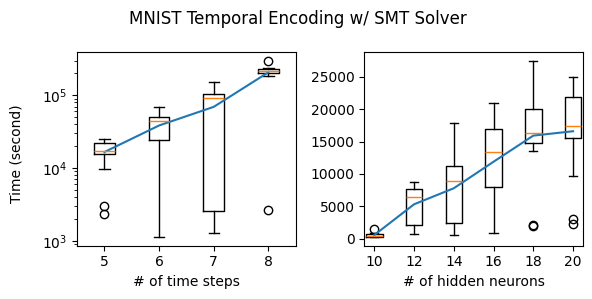

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


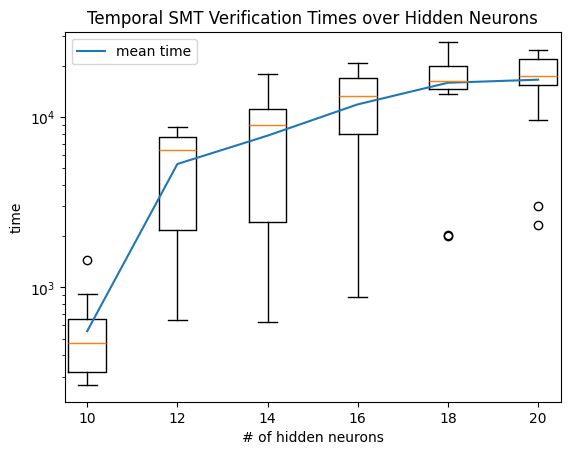

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


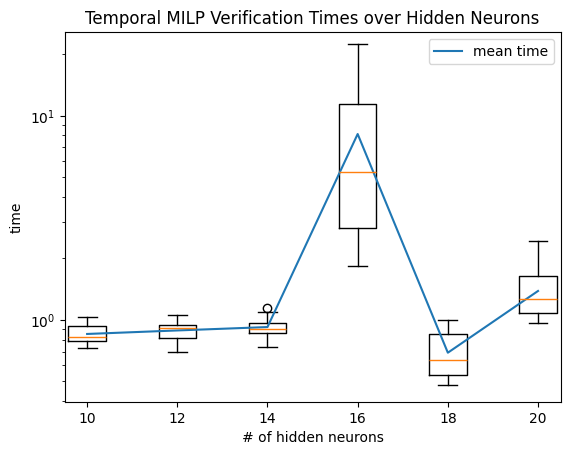

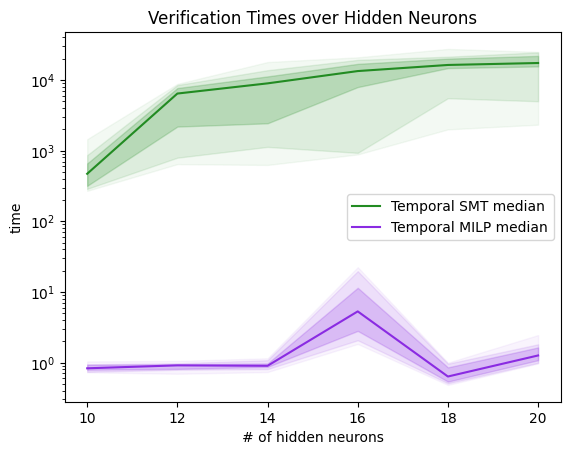

In [14]:
groups = [
    """log/06112104_mnist_latency_z3_5_784_20_10_delta(1,).log log/06112105_mnist_latency_z3_6_784_20_10_delta(1,).log log/06112138_mnist_latency_z3_7_784_20_10_delta(1,).log log/06112138_mnist_latency_z3_8_784_20_10_delta(1,).log""".split(' '),
    """log/06101421_mnist_latency_z3_5_784_10_10_delta(1,).log log/06131254_mnist_latency_z3_5_784_12_10_delta(1,).log log/06130909_mnist_latency_z3_5_784_14_10_delta(1,).log log/06130704_mnist_latency_z3_5_784_16_10_delta(1,).log log/06130832_mnist_latency_z3_5_784_18_10_delta(1,).log log/06112104_mnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST Temporal Encoding w/ SMT Solver",
                [[5,6,7,8],[10,12,14,16,18,20]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[True, False])

# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files1 = """log/06101421_mnist_latency_z3_5_784_10_10_delta(1,).log log/06131254_mnist_latency_z3_5_784_12_10_delta(1,).log log/06130909_mnist_latency_z3_5_784_14_10_delta(1,).log log/06130704_mnist_latency_z3_5_784_16_10_delta(1,).log log/06130832_mnist_latency_z3_5_784_18_10_delta(1,).log log/06112104_mnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
plot_files(files1,
           "Temporal SMT Verification Times over Hidden Neurons",
           [10,12,14,16,18,20],
           "# of hidden neurons",
           "time")
files2 = """log/08310125_mnist_latency_milp_5_784_10_10_delta(1,).log log/08310511_mnist_latency_milp_5_784_12_10_delta(1,).log log/08312223_mnist_latency_milp_5_784_14_10_delta(1,).log log/09011524_fmnist_latency_milp_5_784_16_10_delta(1,).log log/09021833_mnist_latency_milp_5_784_18_10_delta(1,).log log/09121700_mnist_latency_milp_5_784_20_10_delta(1,).log""".split(' ')
plot_files(files2,
           "Temporal MILP Verification Times over Hidden Neurons",
           [10,12,14,16,18,20],
           "# of hidden neurons",
           "time")

# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files = [files1, files2]
compare_plot_files(files,
           "Verification Times over Hidden Neurons",
           [10,12,14,16,18,20],
           "# of hidden neurons",
           "time",
           group_labels=["Temporal SMT median", "Temporal MILP median"],
           log=True)

sample 48540 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.


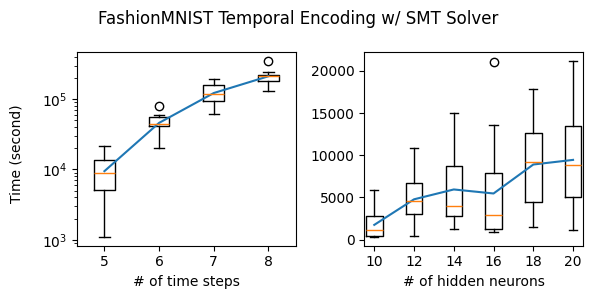

In [15]:
# groups = [
#     """log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log log/08120947_fmnist_latency_z3_6_784_20_10_delta(1,).log log/08120948_fmnist_latency_z3_7_784_20_10_delta(1,).log log/08120955_fmnist_latency_z3_8_784_20_10_delta(1,).log""".split(' '),
#     """log/08101714_fmnist_latency_z3_5_784_10_10_delta(1,).log log/08102345_fmnist_latency_z3_5_784_12_10_delta(1,).log log/08102020_fmnist_latency_z3_5_784_14_10_delta(1,).log log/08101935_fmnist_latency_z3_5_784_16_10_delta(1,).log log/08101743_fmnist_latency_z3_5_784_18_10_delta(1,).log log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
# ]
# plot_two_groups(groups,
#                 "FashionMNIST Temporal Encoding w/ SMT Solver",
#                 [[5,6,7,8],[10,12,14,16,18,20]],
#                 ["# of time steps", "# of hidden neurons"],
#                 "Time (second)",
#                 ylogs=[True, False])
groups = [
    """log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log log/08120948_fmnist_latency_z3_7_784_20_10_delta(1,).log log/08120955_fmnist_latency_z3_8_784_20_10_delta(1,).log""".split(' '),
    """log/08151410_fmnist_latency_z3_5_784_10_10_delta(1,).log log/08152154_fmnist_latency_z3_5_784_12_10_delta(1,).log log/08152154_fmnist_latency_z3_5_784_14_10_delta(1,).log log/08101935_fmnist_latency_z3_5_784_16_10_delta(1,).log log/08151440_fmnist_latency_z3_5_784_18_10_delta(1,).log log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "FashionMNIST Temporal Encoding w/ SMT Solver",
                [[5,6,7,8],[10,12,14,16,18,20]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[True, False])

5 repeats detected.
5 repeats detected.


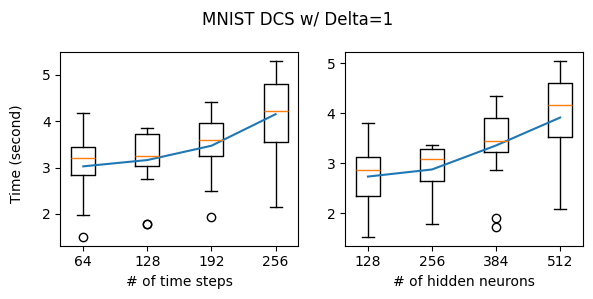

In [16]:
groups = [
    """log/08151714_rep_5_mnist_latency_np_64_784_512_10_delta(1,).log log/08151716_rep_5_mnist_latency_np_128_784_512_10_delta(1,).log log/08151719_rep_5_mnist_latency_np_192_784_512_10_delta(1,).log log/08151721_rep_5_mnist_latency_np_256_784_512_10_delta(1,).log""".split(' '),
    """log/08151806_rep_5_mnist_latency_np_256_784_128_10_delta(1,).log log/08151807_rep_5_mnist_latency_np_256_784_256_10_delta(1,).log log/08151810_rep_5_mnist_latency_np_256_784_384_10_delta(1,).log log/08151721_rep_5_mnist_latency_np_256_784_512_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST DCS w/ Delta=1",
                [[64,128,192,256],[128, 256, 384, 512]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[False, False])

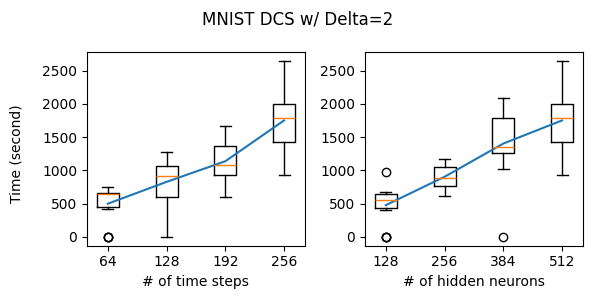

In [17]:
groups = [
    """log/08141748_mnist_latency_np_64_784_512_10_delta(2,).log log/08141748_mnist_latency_np_128_784_512_10_delta(2,).log log/08141748_mnist_latency_np_192_784_512_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' '),
    """log/08141325_mnist_latency_np_256_784_128_10_delta(2,).log log/08141337_mnist_latency_np_256_784_256_10_delta(2,).log log/08141442_mnist_latency_np_256_784_384_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST DCS w/ Delta=2",
                [[64,128,192,256],[128, 256, 384, 512]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[False, False])

In [18]:
def compare_hist_files(files:list[list[LiteralString]],
                       title:str,
                       xlabel:str,
                       ylabel:str,
                       group_labels:list[str]|None=None):
    hist_x:list[list[float]] = [list() for _ in range(len(files))]
    M = -float("inf")
    for group_idx, group_files in enumerate(files):
        times_dict = extract_log(group_files)
        for sample_times in times_dict.values():
            hist_x[group_idx].extend(sample_times)
            for time in sample_times:
                if time != float("inf"):
                    M = max(time, M)
        # array = np.array(list(times_dict.values()))
        # M = max(M, np.max(array[array!=float("inf")]))
        # label_perm = []
        # for sample_idx, times_over_sample in times_dict.items():
        #     label_perm.append(sample_idx)
        #     for sample_time in times_over_sample:
        #         hist_x[group_idx].append(sample_time)
    
    print(hist_x)
    
    # inf_representation = M + 10**np.floor(np.log10(M))
    inf_representation = M
    for group in hist_x:
        for i, time in enumerate(group):
            group[i] = time if time != float("inf") else inf_representation
    
    if group_labels is not None:
        plt.hist(hist_x, label=group_labels, orientation='horizontal')
    else:
        plt.hist(hist_x, orientation='horizontal')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

sample 48265 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta(1,).log.
sample 44348 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta(1,).log.
sample 7296 timeouted at file log/08062234_mnist_baseline_z3_5_784_10_10_delta(3,).log.


/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


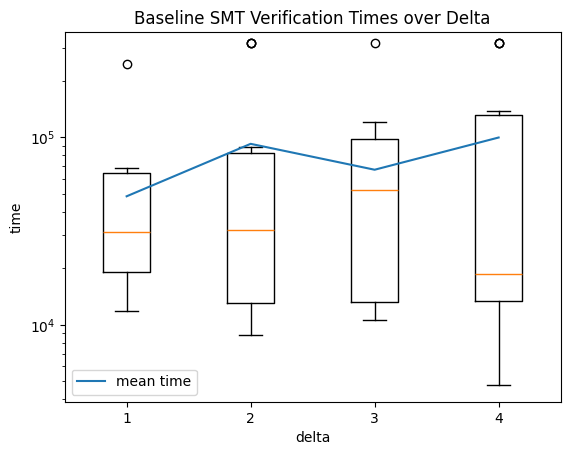

sample 6717 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(3,).log.
sample 7296 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 58469 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 1639 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 16049 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 9144 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 48540 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.


/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


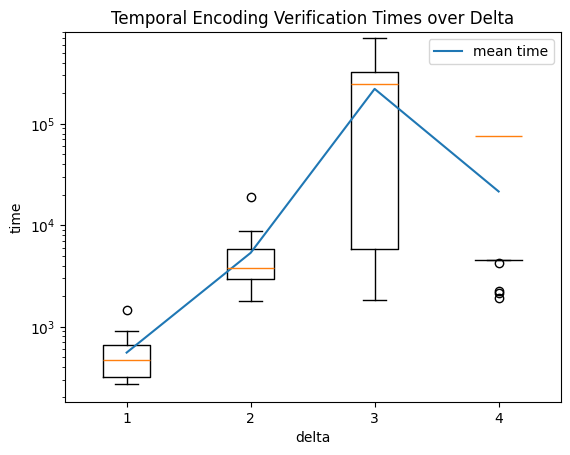

sample 9144 timeouted at file log/08062240_mnist_baseline_np_5_784_10_10_delta(3,).log.
sample 48598 timeouted at file log/08062240_mnist_baseline_np_5_784_10_10_delta(3,).log.
sample 48598 timeouted at file log/08070837_mnist_baseline_np_5_784_10_10_delta(4,).log.


/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


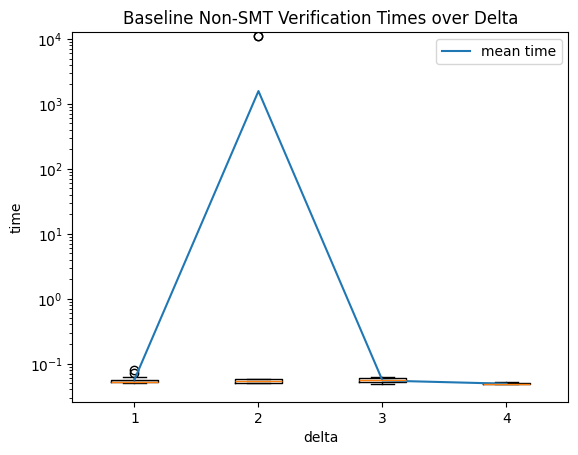

sample 7296 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 58469 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 1639 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 41905 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 16049 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 9144 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 48540 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.
sample 6717 timeouted at file log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log.


/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


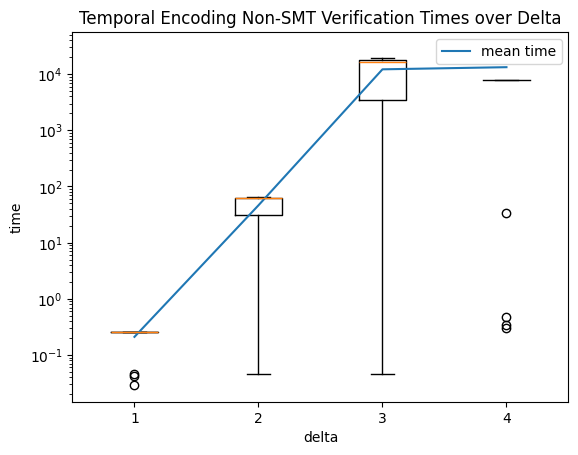

sample 48265 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta(1,).log.
sample 44348 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta(1,).log.
sample 7296 timeouted at file log/08062234_mnist_baseline_z3_5_784_10_10_delta(3,).log.
sample 6717 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(3,).log.
sample 7296 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 58469 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 1639 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 16049 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 9144 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.
sample 48540 timeouted at file log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log.


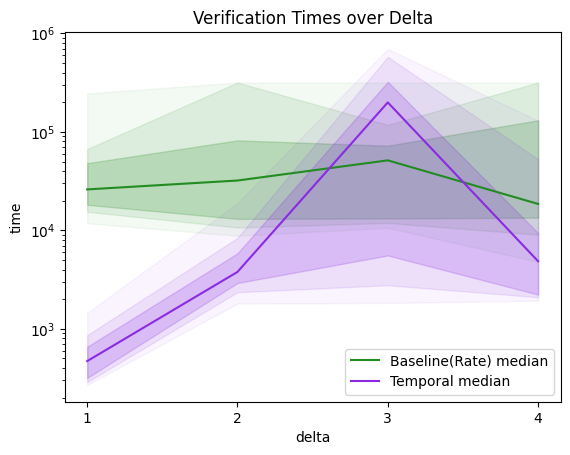

In [19]:
# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files1 = """log/08062232_mnist_baseline_z3_5_784_10_10_delta(1,).log log/08062233_mnist_baseline_z3_5_784_10_10_delta(2,).log log/08062234_mnist_baseline_z3_5_784_10_10_delta(3,).log log/08062234_mnist_baseline_z3_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files1,
           "Baseline SMT Verification Times over Delta",
           range(1, 4+1),
           "delta",
           "time")
files2 = """log/06101421_mnist_latency_z3_5_784_10_10_delta(1,).log log/07250939_mnist_latency_z3_5_784_10_10_delta(2,).log log/07250940_mnist_latency_z3_5_784_10_10_delta(3,).log log/07250940_mnist_latency_z3_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files2,
           "Temporal Encoding Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

files3 = """log/08062246_mnist_baseline_np_5_784_10_10_delta(1,).log log/08062246_mnist_baseline_np_5_784_10_10_delta(2,).log log/08062240_mnist_baseline_np_5_784_10_10_delta(3,).log log/08070837_mnist_baseline_np_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files3,
           "Baseline Non-SMT Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

files4 = """log/08061731_mnist_latency_np_5_784_10_10_delta(1,).log log/08062011_mnist_latency_np_5_784_10_10_delta(2,).log log/08062016_mnist_latency_np_5_784_10_10_delta(3,).log log/08122111_mnist_latency_np_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files4,
           "Temporal Encoding Non-SMT Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files = [files1, files2]
compare_plot_files(files,
           "Verification Times over Delta",
           range(1, 4+1),
           "delta",
           "time",
           group_labels=["Baseline(Rate) median", "Temporal median"],
           log=True)

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


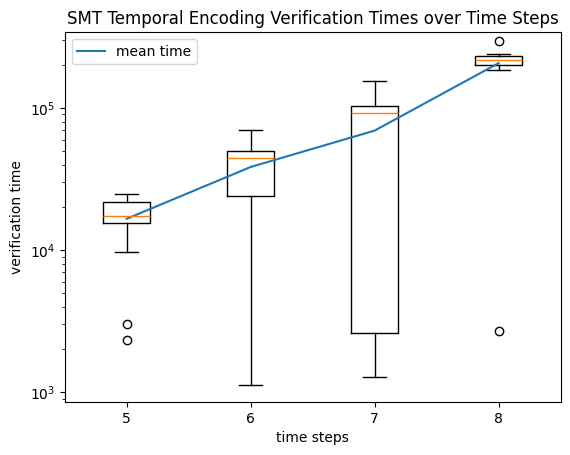

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


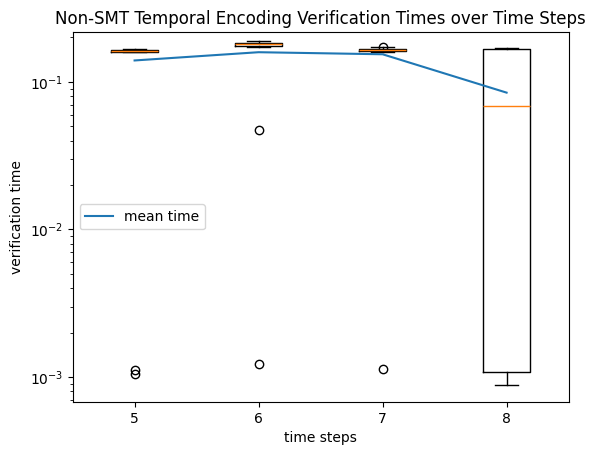

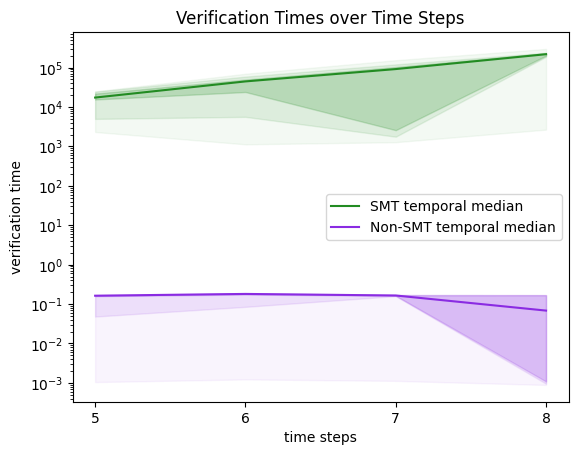

In [20]:
# files1 = """log/06112259_baseline_5_784_20_10_delta(1,).log log/06112307_baseline_6_784_20_10_delta(1,).log log/06120801_baseline_7_784_20_10_delta(1,).log log/06120949_baseline_8_784_20_10_delta_(1,).log""".split(' ')
# plot_files(files1,
#            "Rate Encoding Verification Times over Time Steps",
#            [5, 6, 7, 8],
#            "time steps",
#            "verification time")
files2 = """log/06112104_mnist_latency_z3_5_784_20_10_delta(1,).log log/06112105_mnist_latency_z3_6_784_20_10_delta(1,).log log/06112138_mnist_latency_z3_7_784_20_10_delta(1,).log log/06112138_mnist_latency_z3_8_784_20_10_delta(1,).log""".split(' ')
plot_files(files2,
           "SMT Temporal Encoding Verification Times over Time Steps",
           [5, 6, 7, 8],
           "time steps",
           "verification time")
files3 = """log/08062027_mnist_latency_np_5_784_20_10_delta(1,).log log/08062027_mnist_latency_np_6_784_20_10_delta(1,).log log/08062028_mnist_latency_np_7_784_20_10_delta(1,).log log/08062028_mnist_latency_np_8_784_20_10_delta(1,).log""".split(' ')
plot_files(files3,
           "Non-SMT Temporal Encoding Verification Times over Time Steps",
           [5, 6, 7, 8],
           "time steps",
           "verification time")
files = [files2, files3]
compare_plot_files(
    files,
    "Verification Times over Time Steps",
    [5, 6, 7, 8],
    "time steps",
    "verification time",
    group_labels=["SMT temporal median", "Non-SMT temporal median"],
    log=True
)

sample 7296 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 6717 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 14628 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 1639 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 41905 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 16049 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 48598 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 9144 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 48540 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 35741 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 14628 timeouted at file log/06140407_mnist_baseline_z3_5_784_14_10_delta(1,).log.
sample 58469 timeouted at

/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


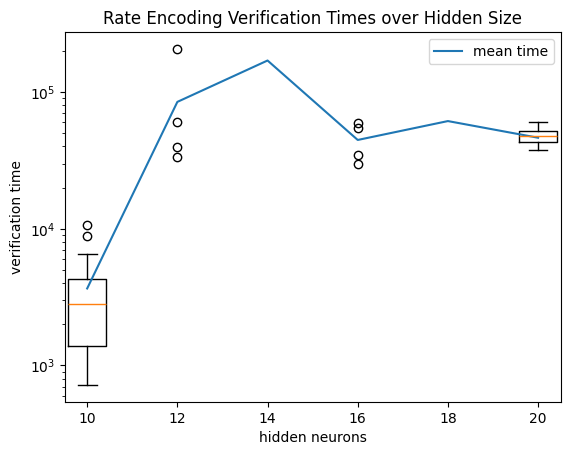

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


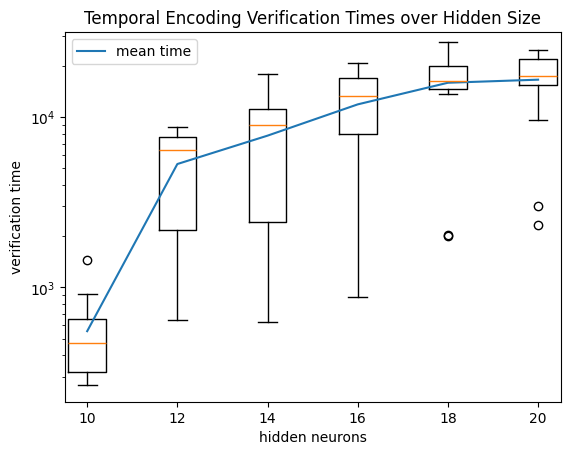

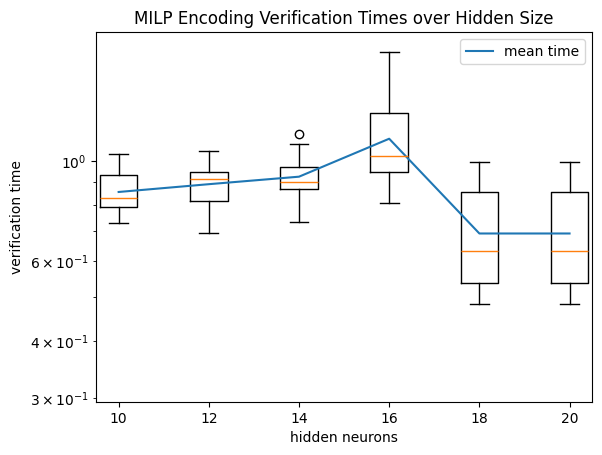

sample 7296 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 6717 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 14628 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 1639 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 41905 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 16049 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 48598 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 9144 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 48540 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 35741 timeouted at file log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log.
sample 14628 timeouted at file log/06140407_mnist_baseline_z3_5_784_14_10_delta(1,).log.
sample 58469 timeouted at

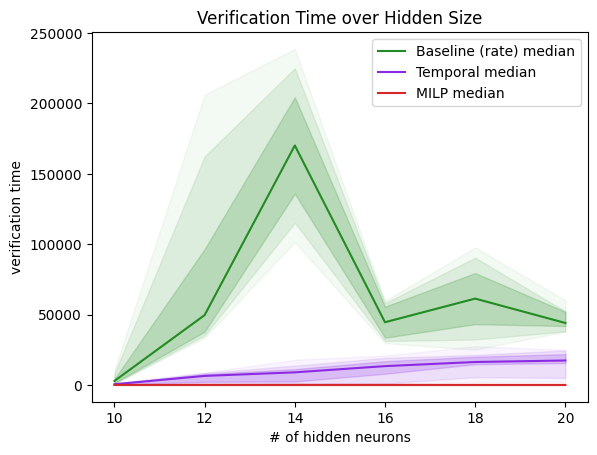

In [21]:
files1 = """log/06071307_mnist_baseline_z3_5_784_10_10_delta(1,).log log/06140808_mnist_baseline_z3_5_784_12_10_delta(1,).log log/06140407_mnist_baseline_z3_5_784_14_10_delta(1,).log log/06131502_mnist_baseline_z3_5_784_16_10_delta(1,).log log/06131451_mnist_baseline_z3_5_784_18_10_delta(1,).log log/06112259_mnist_baseline_z3_5_784_20_10_delta(1,).log""".split(' ')
plot_files(files1,
           "Rate Encoding Verification Times over Hidden Size",
           [10, 12, 14, 16, 18, 20],
           "hidden neurons",
           "verification time")

files2 = """log/06101421_mnist_latency_z3_5_784_10_10_delta(1,).log log/06131254_mnist_latency_z3_5_784_12_10_delta(1,).log log/06130909_mnist_latency_z3_5_784_14_10_delta(1,).log log/06130704_mnist_latency_z3_5_784_16_10_delta(1,).log log/06130832_mnist_latency_z3_5_784_18_10_delta(1,).log log/06112104_mnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
plot_files(files2,
           "Temporal Encoding Verification Times over Hidden Size",
           [10, 12, 14, 16, 18, 20],
           "hidden neurons",
           "verification time")

files3 = """log/08310125_mnist_latency_milp_5_784_10_10_delta(1,).log log/08310511_mnist_latency_milp_5_784_12_10_delta(1,).log log/08312223_mnist_latency_milp_5_784_14_10_delta(1,).log log/09011524_mnist_latency_milp_5_784_16_10_delta(1,).log log/09021833_mnist_latency_milp_5_784_18_10_delta(1,).log log/09021833_mnist_latency_milp_5_784_18_10_delta(1,).log""".split(' ')
plot_files(files3,
           "MILP Encoding Verification Times over Hidden Size",
           [10, 12, 14, 16, 18, 20],
           "hidden neurons",
           "verification time")

files = [files1, files2, files3]
compare_plot_files(files,
                   "Verification Time over Hidden Size",
                   [10, 12, 14, 16, 18, 20],
                   "# of hidden neurons",
                   "verification time",
                   group_labels=["Baseline (rate) median", "Temporal median", "MILP median"])

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


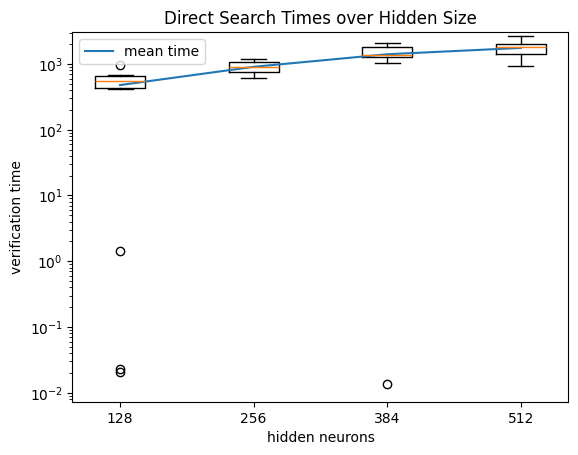

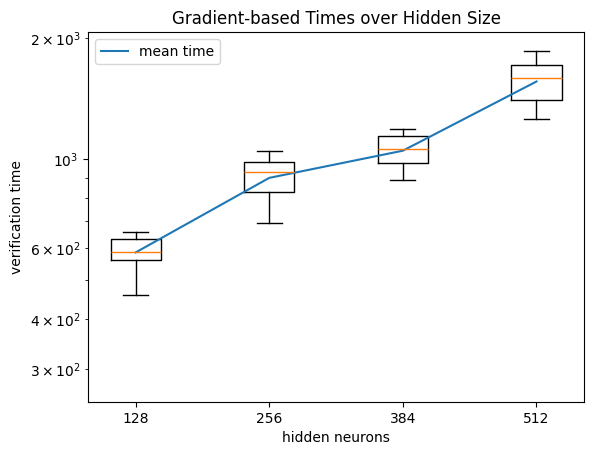

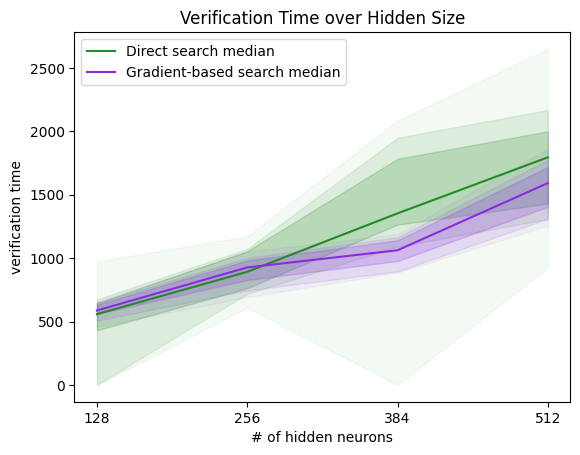

In [22]:
files1 = """log/08141325_mnist_latency_np_256_784_128_10_delta(2,).log log/08141337_mnist_latency_np_256_784_256_10_delta(2,).log log/08141442_mnist_latency_np_256_784_384_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' ')
plot_files(files1,
           "Direct Search Times over Hidden Size",
           [128, 256, 384, 512],
           "hidden neurons",
           "verification time")

files2 = """log/09152055_mnist_latency_np-adv_256_784_128_10_delta(2,).log log/09152313_mnist_latency_np-adv_256_784_256_10_delta(2,).log log/09160245_mnist_latency_np-adv_256_784_384_10_delta(2,).log log/09160653_mnist_latency_np-adv_256_784_512_10_delta(2,).log""".split(' ')
plot_files(files2,
           "Gradient-based Times over Hidden Size",
           [128, 256, 384, 512],
           "hidden neurons",
           "verification time")

files = [files1, files2]
compare_plot_files(files,
                   "Verification Time over Hidden Size",
                   [128, 256, 384, 512],
                   "# of hidden neurons",
                   "verification time",
                   group_labels=["Direct search median", "Gradient-based search median"])

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


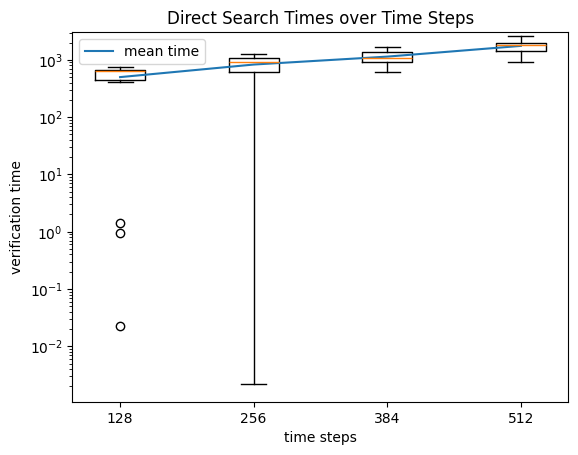

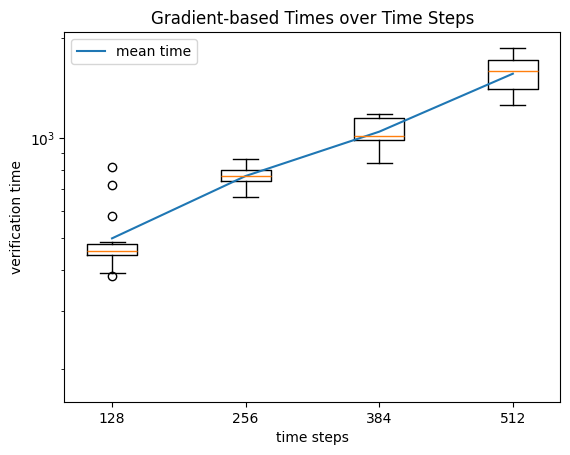

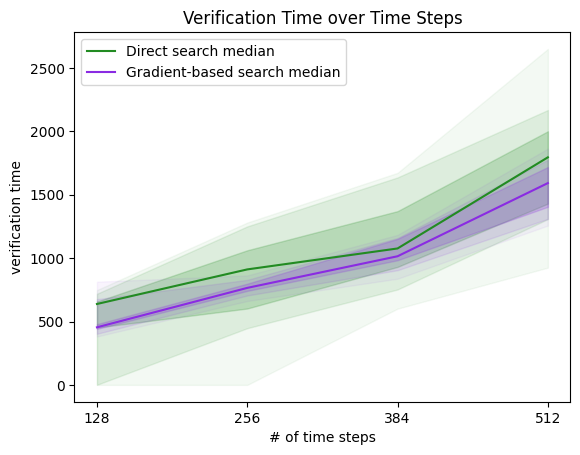

In [23]:
files1 = """log/08141748_mnist_latency_np_64_784_512_10_delta(2,).log log/08141748_mnist_latency_np_128_784_512_10_delta(2,).log log/08141748_mnist_latency_np_192_784_512_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' ')
plot_files(files1,
           "Direct Search Times over Time Steps",
           [128, 256, 384, 512],
           "time steps",
           "verification time")

files2 = """log/09161654_mnist_latency_np-adv_64_784_512_10_delta(2,).log log/09161851_mnist_latency_np-adv_128_784_512_10_delta(2,).log log/09162153_mnist_latency_np-adv_192_784_512_10_delta(2,).log log/09160653_mnist_latency_np-adv_256_784_512_10_delta(2,).log""".split(' ')
plot_files(files2,
           "Gradient-based Times over Time Steps",
           [128, 256, 384, 512],
           "time steps",
           "verification time")

files = [files1, files2]
compare_plot_files(files,
                   "Verification Time over Time Steps",
                   [128, 256, 384, 512],
                   "# of time steps",
                   "verification time",
                   group_labels=["Direct search median", "Gradient-based search median"])

/tmp/ipykernel_3300900/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


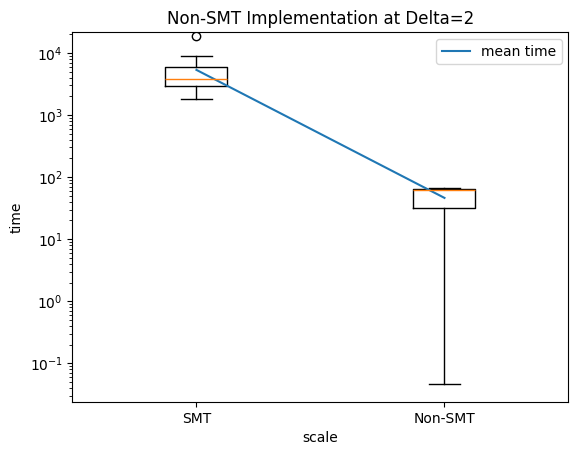

In [24]:
files = """log/07250939_mnist_latency_z3_5_784_10_10_delta(2,).log log/08062011_mnist_latency_np_5_784_10_10_delta(2,).log""".split(' ')
plot_files(files,
           "Non-SMT Implementation at Delta=2",
           range(1,2+1),
           "scale",
           "time",
           xtick_labels=["SMT", "Non-SMT"])

In [25]:
img = np.array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 0, 2, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 0, 0, 0, 1, 4, 4, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 1, 4, 2, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 1, 3, 4, 2, 0, 2, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 3, 4, 4, 3, 0, 0, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 2, 4, 4, 4, 1, 0, 0, 0, 0, 1, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 4, 4, 4, 3, 0, 0, 0, 0, 0, 1, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 1, 3, 4, 2, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 1, 1, 3, 4, 4, 2, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4]])
pertd_img = np.copy(img)
pertd_img[25,7] -= 1
pertd_img[12,17] += 2
pertd_img[5,25] -= 1

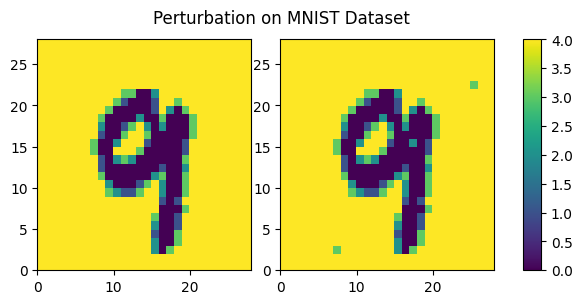

In [26]:

fig, axes = plt.subplots(1, 3, width_ratios=[0.48, 0.48, 0.04])
fig.set_size_inches(6.5, 3)
axes[0].pcolor(img[::-1])
pc = axes[1].pcolor(pertd_img[::-1])

fig.colorbar(pc, ax=axes[1], cax=axes[2])
fig.suptitle("Perturbation on MNIST Dataset")
fig.savefig("PertExample.pdf")